In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import pickle as pkl
from itertools import chain
import copy
import tqdm

In [2]:
import torch

from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, BertModel
import torchaudio

In [3]:
import nltk
import re
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# some funcs

In [4]:
class EarlyStopping():
    def __init__(self, min_delta=0.005, tolerance=10):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.flag = False
        self.min_loss = 1000

    def __call__(self, val_loss):
        if (val_loss - self.min_loss) > self.min_delta:
            self.counter += 1
            print(f' counter = {self.counter}')
            if self.counter >= self.tolerance:
                self.flag = True
        self.min_loss = val_loss if val_loss < self.min_loss else self.min_loss

In [5]:
def train_one_epoch(model, train_dataloader, loss_func, optimizer, device):
  model.train()
  epoch_loss = []
  for (local_head_batch, local_rev_batch, local_label) in train_dataloader:
    (local_head_batch, local_rev_batch, local_label) = (local_head_batch.to(device), local_rev_batch.to(device), local_label.to(device))
    optimizer.zero_grad()
    try:
        y_pred = model.forward(local_head_batch, local_rev_batch)
    except Exception as e:
        print(local_head_batch, e)
    curr_loss = criterion.forward(y_pred, local_label)
    curr_loss.backward()
    optimizer.step()
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

#use with torch.no_grad()
def val_one_epoch(model, val_dataloader, loss_func, device):
  model.eval()
  epoch_loss = []
  for (local_head_batch, local_rev_batch, local_label) in val_dataloader:
    (local_head_batch, local_rev_batch, local_label) = (local_head_batch.to(device), local_rev_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_head_batch, local_rev_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

def test_model(model, test_dataloader, device, classes):
  model.eval()
  test_hits = 0
  total = 0
  confusion_matrix = torch.zeros(len(classes), len(classes))
  for (local_head_batch, local_rev_batch, local_label) in test_dataloader:
    (local_head_batch, local_rev_batch, local_label) = (local_head_batch.to(device), local_rev_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_head_batch, local_rev_batch)
    _, preds = torch.max(y_pred, 1)
    test_hits += torch.sum(preds.view(-1) == local_label.view(-1))
    total += torch.numel(preds.view(-1))
    for t, p in zip(local_label.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix, test_hits, total

In [6]:
class Transpose(torch.nn.Module):
    def __init__(self, dim0, dim1):
        super(Transpose, self).__init__()
        self.dim0 = dim0
        self.dim1 = dim1

    def forward(self, x):
        x = torch.transpose(x, self.dim0, self.dim1)
        return x

In [7]:
class GetFeaturesFromRNN(torch.nn.Module):
    def forward(self, x):
        x, _ = x
        if len(x.shape) == 3:
            return x[:, -1, :]
        elif len(x.shape) == 2:
            return x[:, -1]

In [8]:
class Model(torch.nn.Module):
  def __init__(self, output_dim,
               vocab_size, embedding_dim,
               in_channels):
    super(Model, self).__init__()
    self.text_features = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim=embedding_dim, padding_idx=0),
        nn.Dropout(0.25),
        Transpose(dim0=1, dim1=2),
        nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.MaxPool1d(2),
        Transpose(dim0=1, dim1=2),
        nn.LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5),
        GetFeaturesFromRNN(),
        nn.Flatten()
    )
    self.mfcc_features = nn.Sequential(
        nn.Conv1d(in_channels=in_channels, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.MaxPool1d(8),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Flatten()
    )
    self.classificator = nn.Sequential(
        nn.Linear(128+1152, (128+1152)*2),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear((128+1152)*2, (128+1152)//4),
        nn.Dropout(p=0.5),
        nn.Linear((128+1152)//4, (128+1152)//8),
        nn.Dropout(p=0.5),
        nn.Linear((128+1152)//8, output_dim)
    )


  def forward(self, x0, x1):
    x0 = self.text_features.forward(x0)
    x1 = self.mfcc_features.forward(x1)
    x = torch.cat((x0, x1), 1)
    x = self.classificator.forward(x)
    return x

In [9]:
class Model2(torch.nn.Module):
  def __init__(self, output_dim, in_channels):
    super(Model2, self).__init__()
    self.mfcc_features = nn.Sequential(
        nn.Conv1d(in_channels=in_channels, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.MaxPool1d(8),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1),
        nn.ReLU(),
        nn.Flatten()
    )

    self.classificator = nn.Sequential(
        nn.Linear(1152, (1152)*2),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear((1152)*2, (1152)//4),
        nn.Dropout(p=0.5),
        nn.Linear((1152)//4, (1152)//8),
        nn.Dropout(p=0.5),
        nn.Linear((1152)//8, output_dim)
    )

  def forward(self, x0, x1):
    x1 = self.mfcc_features.forward(x1)
    x = self.classificator.forward(x1)
    return x

In [10]:
class DatasetHuBERT(torch.utils.data.Dataset):
    def __init__(self, df):
        self.class_dic = {
            'angry': 0,
            'neutral': 1,
            'positive': 2,
            'sad': 3
        }
        
        self.df = copy.deepcopy(df)
        self.df['label'] = self.df['annotator_emo'].apply(self.label_emo)
        
    def create_inputs(self, path):
        waveform, sr = torchaudio.load(path)
        transform = torchaudio.transforms.Resample(sr, 16000)
        inputs = self.processor(waveform, return_tensors="pt", padding="longest").input_values
        waveform = transform(waveform)
        inputs = self.feature_extractor(
            waveform, 
            sampling_rate=self.feature_extractor.sampling_rate, 
            return_tensors="pt",
            padding=True,
            max_length=5 * 16000,
            truncation=True
        )
        return inputs['input_values']

    def label_emo(self, text):
        return self.class_dic[text]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx]['audio_path'], torch.tensor(self.df.iloc[idx]['label'])

In [11]:
class Vocab:
    def __init__(self, data:list, spec_symb=True): # data - list of tokens
        self.spec_list = ['<PAD>', '<UNK>']
        self.create_tokens_set(data)


        if spec_symb:
            self.idx_to_token = {i+2: v for i,v in enumerate(self.tokens)}
            self.token_to_idx = {v: i+2 for i,v in enumerate(self.tokens)}
            self.idx_to_token[0] = '<PAD>'
            self.token_to_idx['<PAD>'] = 0
            self.idx_to_token[1] = '<UNK>'
            self.token_to_idx['<UNK>'] = 1
        else:
            self.idx_to_token = {i: v for i,v in enumerate(self.tokens)}
            self.token_to_idx = {v: i for i,v in enumerate(self.tokens)}


    def create_tokens_set(self, data):
        self.tokens = list(set([item for item in data if item not in self.spec_list]))

    def __len__(self):
        return len(self.token_to_idx)

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.class_dic = {
            'angry': 0,
            'neutral': 1,
            'positive': 2,
            'sad': 3
        }
        self.df = copy.deepcopy(df)
        self.df['new_text'] = self.df['speaker_text'].apply(self.clean_text)

        self.max_len = len(max(self.df['new_text'], key=len))
        self.df['new_text'] = self.df['new_text'].apply(self.pad_text, max_len=self.max_len)

        self.df['label'] = self.df['annotator_emo'].apply(self.label_emo)

        self.vocab = Vocab(list(chain.from_iterable(self.df['new_text'])), spec_symb=True)

        self.df['idx_text'] = self.df['new_text'].apply(self.text2num)



    def clean_text(self, text):
        stemmer = SnowballStemmer('russian')
        lemmatizer = WordNetLemmatizer()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = text.lower()
        text = word_tokenize(text)
        text = [lemmatizer.lemmatize(word) for word in text]
        text = ' '.join(text)
        text = word_tokenize(text)
        text = [stemmer.stem(word) for word in text]
        return text

    def pad_text(self, target, max_len):
        diff = max_len - len(target)
        for i in range(diff):
            target.append('<PAD>')
        return target

    def label_emo(self, text):
        return self.class_dic[text]

    def text2num(self, text):#text is list of tokens
        return [self.vocab.token_to_idx.get(token, 1) for token in text]

    def num2text(self, array):
        return [self.vocab.idx_to_token.get(token, self.vocab.spec_list[1]) for token in text]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (torch.tensor(self.df['idx_text'].iloc[idx]), torch.tensor(self.df['mfcc'].iloc[idx]), torch.tensor(self.df['label'].iloc[idx]))

In [13]:
def oversample(df):
    max_size = df['annotator_emo'].value_counts().max()
    lst = [df]
    for cls_idx, group in df.groupby('annotator_emo'):
        lst.append(group.sample(max_size-len(group), replace=True))
    new_df = pd.concat(lst)
    return new_df

# data prep

In [13]:
crowd_train = open(r'D:\data\serialized\crowd_train.ser', 'rb')
crowd_train = pkl.load(crowd_train)

crowd_test = open(r'D:\data\serialized\crowd_test.ser', 'rb')
crowd_test = pkl.load(crowd_test)

podcast_train = open(r'D:\data\serialized\podcast_train.ser', 'rb')
podcast_train = pkl.load(podcast_train)

podcats_test = open(r'D:\data\serialized\podcast_test.ser', 'rb')
podcats_test = pkl.load(podcats_test)

### crowd_train

In [14]:
crowd_train.head(1)

,audio_path,duration,annotator_emo,speaker_text,mfcc
0,D:\data\dusha\crowd\crowd_train\wavs\475e76f77...,2.453,angry,не надо не надо не надо не надо,"[[-249.52695, -185.88918, -257.38525, -660.106..."


<Axes: >

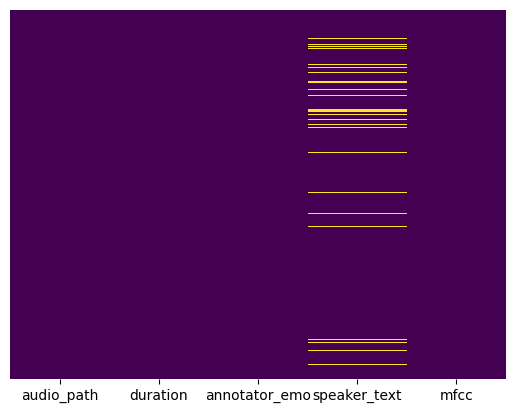

In [15]:
sns.heatmap(crowd_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [16]:
crowd_train = crowd_train[crowd_train['mfcc'].notna()]

<Axes: >

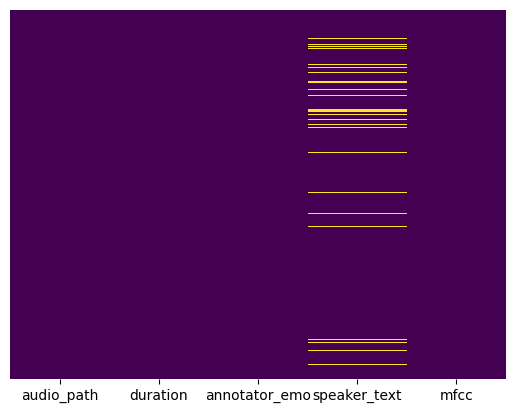

In [17]:
sns.heatmap(crowd_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [18]:
print(f'len of crowd_train becomes {len(crowd_train)}')

len of crowd_train becomes 605943


### crowd_test

In [19]:
crowd_test.head(1)

,audio_path,duration,annotator_emo,speaker_text,mfcc
1,D:\data\dusha\crowd\crowd_test\wavs\0166f65a30...,3.7,sad,каким стал сбер,"[[-949.42395, -695.3361, -579.75934, -530.3081..."


<Axes: >

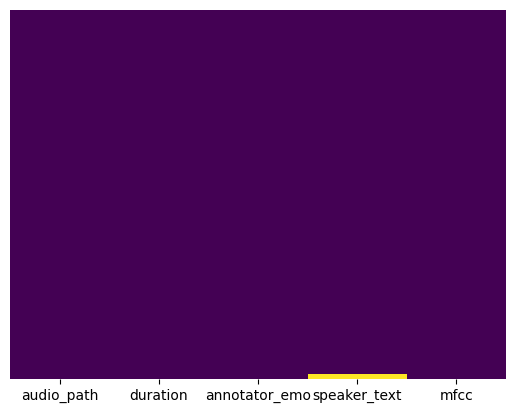

In [20]:
sns.heatmap(crowd_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [21]:
crowd_test = crowd_test[crowd_test['mfcc'].notna()]

<Axes: >

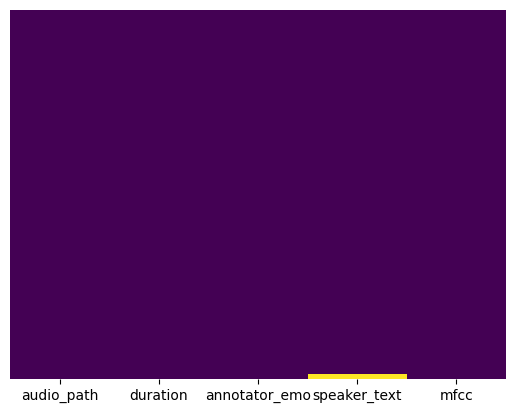

In [22]:
sns.heatmap(crowd_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [23]:
print(f'len of crowd_test becomes {len(crowd_test)}')

len of crowd_test becomes 49133


### podcast_train

In [24]:
podcast_train.head(1)

,audio_path,duration,annotator_emo,speaker_text,mfcc
0,D:\data\dusha\podcast\podcast_train\wavs\857b7...,4.4,neutral,NaN,None


<Axes: >

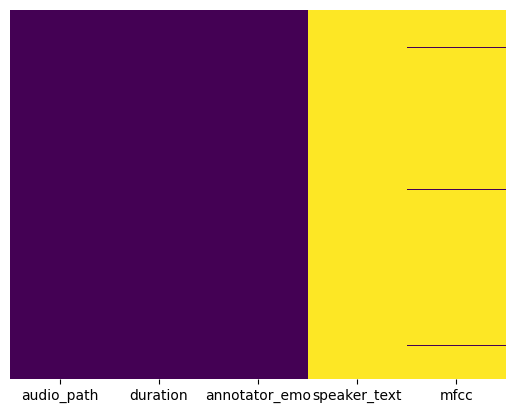

In [25]:
sns.heatmap(podcast_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [26]:
podcast_train = podcast_train[podcast_train['mfcc'].notna()]

<Axes: >

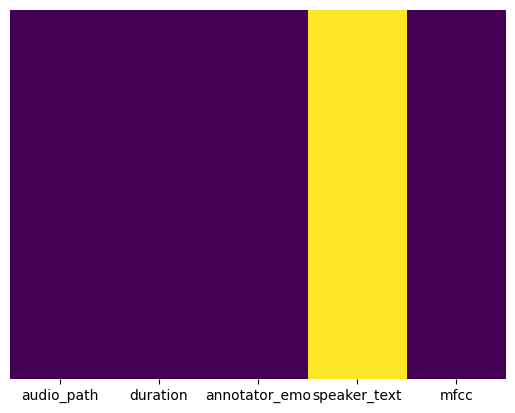

In [27]:
sns.heatmap(podcast_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [28]:
print(f'len of podcast_train becomes {len(podcast_train)}')

len of podcast_train becomes 12262


### podcats_test

In [29]:
podcats_test.head(1)

,audio_path,duration,annotator_emo,speaker_text,mfcc
0,D:\data\dusha\podcast\podcast_test\wavs\9749f1...,3.0,neutral,NaN,None


<Axes: >

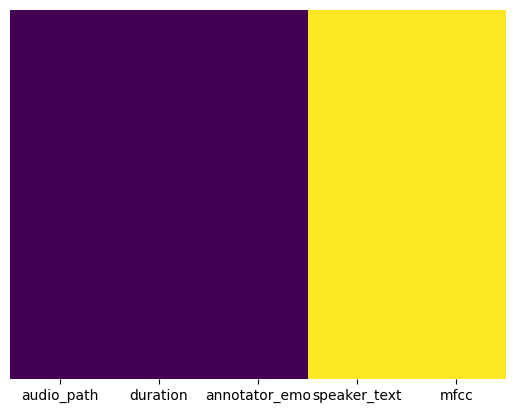

In [30]:
sns.heatmap(podcats_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [31]:
podcats_test = podcats_test[podcats_test['mfcc'].notna()]

In [32]:
print(f'len of podcast_test becomes {len(podcats_test)}')

len of podcast_test becomes 0


### datasets concat and text prep

In [33]:
#учитывая, что подкасты не имеют теста, то мы откажемся от их использования, также откажемся от записей, которые не содержат текста в используемых датасетах

In [34]:
crowd_train = crowd_train[crowd_train['speaker_text'].notna()]
crowd_test = crowd_test[crowd_test['speaker_text'].notna()]

In [35]:
print(len(crowd_train), len(crowd_test))

565077 48502


In [191]:
df = pd.concat([crowd_train, crowd_test], axis=0)
print(len(df))

613579


In [192]:
df = df.sample(frac=1).reset_index(drop=True)

In [187]:
df.head(2)

,audio_path,duration,annotator_emo,speaker_text,mfcc
0,D:\data\dusha\crowd\crowd_train\wavs\ee8c4b383...,4.060000,positive,другой мир третья часть,"[[-617.4648, -614.5307, -621.55347, -629.93024..."
1,D:\data\dusha\crowd\crowd_train\wavs\246c2d459...,2.925312,sad,расскажи шутки,"[[-716.5156, -630.4661, -630.7716, -687.54395,..."


# classification

## task 2

In [56]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [49]:
def evaluate_model(X, y, model):
	start = time.time()
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	train_time = time.time() - start
	return scores, train_time

In [58]:
new_df = []
for num, item in enumerate(df['mfcc'][0:2000]):
    new_df.append([])
    for i, item2 in enumerate(item):
        for j, item3 in enumerate(item2):
            new_df[num].append(item3)

In [59]:
X = np.array([np.array(xi) for xi in new_df])
del new_df

In [60]:
y = np.array(df['annotator_emo'].iloc[0:2000])

In [61]:
dummyClassifier = DummyClassifier(strategy='most_frequent')
linearClassifier = svm.SVC(kernel = 'linear')
rbfClassifier = svm.SVC(kernel='rbf')
baggingClassifier = BaggingClassifier()

In [62]:
#тест на определение лучшей модели из заданных
res = pd.DataFrame({"mean accuracy":[],
                    "train time": [],
                    "model": []})
res2 = []
models = [dummyClassifier, linearClassifier, rbfClassifier, baggingClassifier]
for i in models:
  scores, train_time = evaluate_model(X, y, i)
  res.loc[len(res.index)] = [np.mean(scores), train_time, i]
  print(i, train_time, np.mean(scores))
  res2.append(scores)
res

DummyClassifier(strategy='most_frequent') 1.6899614334106445 0.5475
SVC(kernel='linear') 68.48928642272949 0.6701
SVC() 79.46580362319946 0.5475
BaggingClassifier() 160.20532822608948 0.6825


,mean accuracy,train time,model
0,0.5475,1.689961,DummyClassifier(strategy='most_frequent')
1,0.6701,68.489286,SVC(kernel='linear')
2,0.5475,79.465804,SVC()
3,0.6825,160.205328,BaggingClassifier()


## task 3

### 1st model (mfcc and text)

In [ ]:
dataset = Dataset(df)

In [ ]:
BATCH_SIZE = 1000
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [ ]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [42]:
in_size = (len(dataset.vocab), dataset[0][1].shape)
out_size = len(dataset.class_dic)
print(f'in = {in_size}, out = {out_size}')

in = (25461, torch.Size([13, 147])), out = 4


In [43]:
model = Model(out_size, len(dataset.vocab), 200, in_size[1][0]).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 9835724


In [44]:
model

Model(
  (text_features): Sequential(
    (0): Embedding(25461, 200, padding_idx=0)
    (1): Dropout(p=0.25, inplace=False)
    (2): Transpose()
    (3): Conv1d(200, 128, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Transpose()
    (8): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5)
    (9): GetFeaturesFromRNN()
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (mfcc_features): Sequential(
    (0): Conv1d(13, 128, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (7): ReLU()
    (8): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (9): ReLU()
    (10): Conv1d(128, 128, kernel_size=(3,), s

In [45]:
next(model.parameters()).is_cuda

True

In [46]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.005, tolerance=10)

In [47]:
train_loss = []
val_loss = []
test_acc = []
for epoch in tqdm.tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None

  8%|██████▎                                                                        | 12/150 [08:05<1:32:06, 40.05s/it]

 counter = 1


 13%|██████████                                                                     | 19/150 [12:45<1:27:28, 40.06s/it]

 counter = 2


 13%|██████████▌                                                                    | 20/150 [13:25<1:26:38, 39.99s/it]

 counter = 3


 14%|███████████                                                                    | 21/150 [14:05<1:25:37, 39.82s/it]

 counter = 4


 15%|███████████▌                                                                   | 22/150 [14:44<1:25:01, 39.86s/it]

 counter = 5


 15%|████████████                                                                   | 23/150 [15:24<1:24:26, 39.89s/it]

 counter = 6


 16%|████████████▋                                                                  | 24/150 [16:04<1:23:21, 39.69s/it]

 counter = 7


 17%|█████████████▏                                                                 | 25/150 [16:43<1:22:37, 39.66s/it]

 counter = 8


 17%|█████████████▋                                                                 | 26/150 [17:23<1:21:42, 39.54s/it]

 counter = 9


 17%|█████████████▋                                                                 | 26/150 [18:02<1:26:04, 41.65s/it]

 counter = 10

early stop at epoch №26


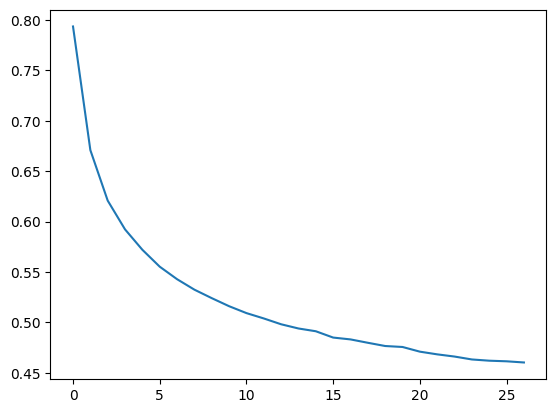

In [48]:
import matplotlib.pyplot as plt
plt.plot([np.mean(x) for x in train_loss])

In [49]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, [0, 1, 2, 3])
torch.cuda.empty_cache() if device == 'cuda' else None

In [50]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 80.1%


<Axes: >

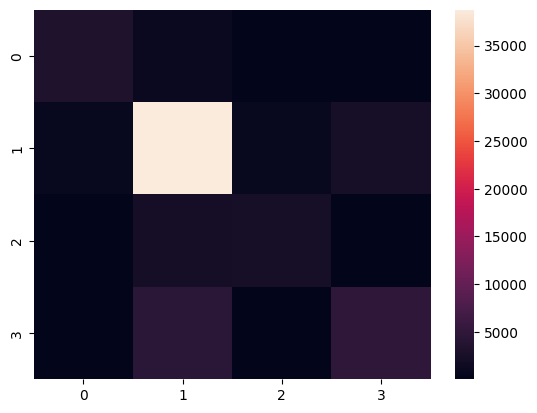

In [51]:
from seaborn import heatmap
heatmap(test_data[0])

In [52]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
            }, r'C:\Users\user\Desktop\dz\nlp\lab6\models\text-mfcc-custom.model')

### 2nd model (mfcc only)

In [ ]:
dataset = Dataset(df)

In [ ]:
BATCH_SIZE = 1000
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [ ]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [53]:
in_size = (dataset[0][1].shape)
out_size = len(dataset.class_dic)
print(f'in = {in_size}, out = {out_size}')

in = torch.Size([13, 147]), out = 4


In [54]:
model = Model2(out_size, in_size[0]).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 3614068


In [55]:
model

Model2(
  (mfcc_features): Sequential(
    (0): Conv1d(13, 128, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (7): ReLU()
    (8): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (9): ReLU()
    (10): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (11): ReLU()
    (12): Dropout(p=0.1, inplace=False)
    (13): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (14): ReLU()
    (15): Flatten(start_dim=1, end_dim=-1)
  )
  (classificator): Sequential(
    (0): Linear(in_features=1152, out_features=2304, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2304, out_features=288, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=288, out_features=144, bias=Tr

In [56]:
next(model.parameters()).is_cuda

True

In [57]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.005, tolerance=10)

In [58]:
train_loss = []
val_loss = []
test_acc = []
for epoch in tqdm.tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None

  9%|██████▊                                                                        | 13/150 [08:22<1:29:23, 39.15s/it]

 counter = 1


 10%|███████▉                                                                       | 15/150 [09:39<1:27:26, 38.86s/it]

 counter = 2


 11%|████████▉                                                                      | 17/150 [11:01<1:28:41, 40.01s/it]

 counter = 3


 13%|██████████▌                                                                    | 20/150 [13:04<1:27:44, 40.50s/it]

 counter = 4


 15%|████████████                                                                   | 23/150 [15:07<1:26:26, 40.84s/it]

 counter = 5


 20%|███████████████▊                                                               | 30/150 [19:55<1:22:29, 41.25s/it]

 counter = 6


 23%|█████████████████▉                                                             | 34/150 [22:42<1:20:15, 41.51s/it]

 counter = 7


 25%|███████████████████▍                                                           | 37/150 [24:46<1:17:51, 41.34s/it]

 counter = 8


 28%|██████████████████████                                                         | 42/150 [28:13<1:14:18, 41.28s/it]

 counter = 9


 28%|██████████████████████                                                         | 42/150 [28:54<1:14:20, 41.30s/it]

 counter = 10

early stop at epoch №42


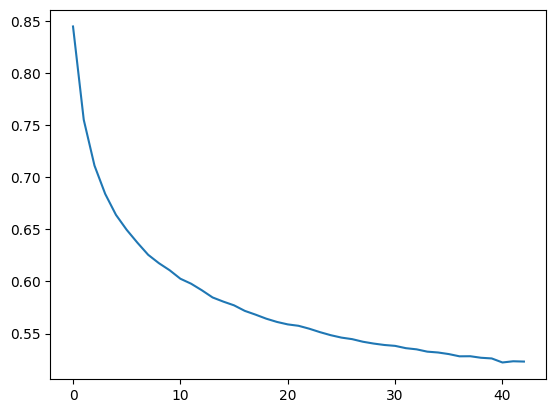

In [59]:
import matplotlib.pyplot as plt
plt.plot([np.mean(x) for x in train_loss])

In [60]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, [0, 1, 2, 3])
torch.cuda.empty_cache() if device == 'cuda' else None

In [61]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 77.7%


<Axes: >

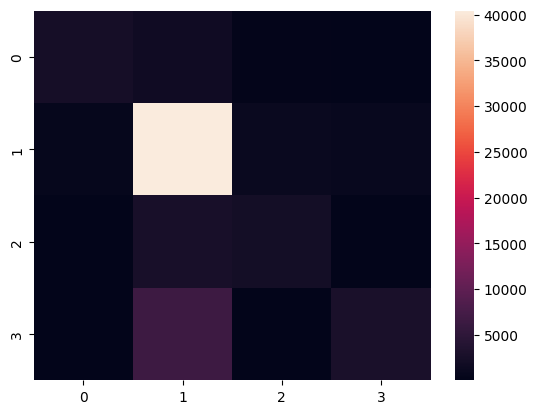

In [62]:
from seaborn import heatmap
heatmap(test_data[0])

In [64]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
            }, r'C:\Users\user\Desktop\dz\nlp\lab6\models\mfcc-custom.model')

### 3rd model (hubert)

#### some funcs

In [70]:
def train_one_epoch(model, train_dataloader, loss_func, optimizer, device):
    model.train()
    epoch_loss = []
    for (local_head_batch, local_label) in train_dataloader:
        processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
        audio = []
        for item in local_head_batch:
            waveform, sr = torchaudio.load(item)
            transform = torchaudio.transforms.Resample(sr, 16000)
            waveform = transform(waveform).squeeze().numpy()
            audio.append(waveform)
        local_head_batch = processor(audio, return_tensors="pt", padding="longest", sampling_rate=16000).input_values
        
        (local_head_batch, local_label) = (local_head_batch.to(device), local_label.to(device))
        optimizer.zero_grad()
        try:
            y_pred = model.forward(local_head_batch)['logits']
        except Exception as e:
            print(local_head_batch, e)
        curr_loss = criterion.forward(y_pred, local_label)
        curr_loss.backward()
        optimizer.step()
        epoch_loss.append(curr_loss.item())
    return np.mean(epoch_loss)

#use with torch.no_grad()
def val_one_epoch(model, val_dataloader, loss_func, device):
    model.eval()
    epoch_loss = []
    for (local_head_batch, local_label) in val_dataloader:
        processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
        audio = []
        for item in local_head_batch:
            waveform, sr = torchaudio.load(item)
            transform = torchaudio.transforms.Resample(sr, 16000)
            waveform = transform(waveform).squeeze().numpy()
            audio.append(waveform)
        local_head_batch = processor(audio, return_tensors="pt", padding="longest", sampling_rate=16000).input_values
        
        (local_head_batch, local_label) = (local_head_batch.to(device), local_label.to(device))
        y_pred = model.forward(local_head_batch)['logits']
        curr_loss = criterion.forward(y_pred, local_label)
        epoch_loss.append(curr_loss.item())
    return np.mean(epoch_loss)

def test_model(model, test_dataloader, device, classes):
    model.eval()
    test_hits = 0
    total = 0
    confusion_matrix = torch.zeros(len(classes), len(classes))
    for (local_head_batch, local_label) in test_dataloader:
        processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
        audio = []
        for item in local_head_batch:
            waveform, sr = torchaudio.load(item)
            transform = torchaudio.transforms.Resample(sr, 16000)
            waveform = transform(waveform).squeeze().numpy()
            audio.append(waveform)
        local_head_batch = processor(audio, return_tensors="pt", padding="longest", sampling_rate=16000).input_values
        
        (local_head_batch, local_label) = (local_head_batch.to(device), local_label.to(device))
        y_pred = model.forward(local_head_batch)['logits']
        _, preds = torch.max(y_pred, 1)
        test_hits += torch.sum(preds.view(-1) == local_label.view(-1))
        total += torch.numel(preds.view(-1))
        for t, p in zip(local_label.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix, test_hits, total

#### processing

In [71]:
dataset = DatasetHuBERT(df.iloc[0:2000])

In [72]:
BATCH_SIZE = 8
INIT_LR = 1e-3
EPOCH = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

In [73]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [74]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [75]:
out_size = len(dataset.class_dic)
print(f'out = {out_size}')

out = 4


In [76]:
model = HubertForSequenceClassification.from_pretrained("facebook/hubert-base-ls960")
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias', 'classifier.weight', 'projector.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


кол-во параметров в модели = 94569090


In [77]:
model.classifier = torch.nn.Linear(256, out_size)

In [78]:
for param in model.hubert.parameters():
    param.requires_grad = False
model = model.to(device)

In [79]:
next(model.parameters()).is_cuda

True

In [80]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.005, tolerance=10)

In [81]:
train_loss = []
val_loss = []
test_acc = []
for epoch in tqdm.tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None

  4%|███▏                                                                            | 4/100 [06:05<2:26:02, 91.27s/it]

 counter = 1


  8%|██████▍                                                                         | 8/100 [12:09<2:19:32, 91.01s/it]

 counter = 2


  9%|███████▏                                                                        | 9/100 [13:40<2:18:13, 91.13s/it]

 counter = 3


 10%|███████▉                                                                       | 10/100 [15:14<2:17:39, 91.77s/it]

 counter = 4


 11%|████████▋                                                                      | 11/100 [16:46<2:16:19, 91.90s/it]

 counter = 5


 12%|█████████▍                                                                     | 12/100 [18:17<2:14:41, 91.84s/it]

 counter = 6


 13%|██████████▎                                                                    | 13/100 [19:51<2:13:43, 92.22s/it]

 counter = 7


 15%|███████████▊                                                                   | 15/100 [22:53<2:09:44, 91.59s/it]

 counter = 8


 16%|████████████▋                                                                  | 16/100 [24:24<2:08:12, 91.58s/it]

 counter = 9


 16%|████████████▋                                                                  | 16/100 [26:01<2:16:35, 97.57s/it]

 counter = 10

early stop at epoch №16


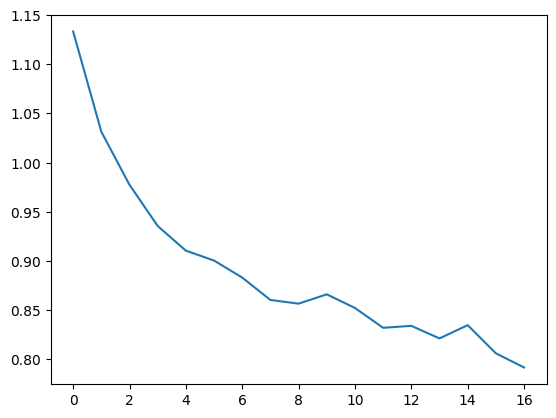

In [82]:
import matplotlib.pyplot as plt
plt.plot([np.mean(x) for x in train_loss])

In [83]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, [0, 1, 2, 3])
torch.cuda.empty_cache() if device == 'cuda' else None

In [84]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 62.5%


<Axes: >

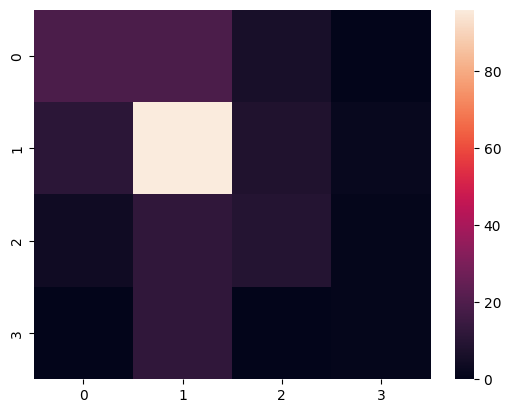

In [85]:
from seaborn import heatmap
heatmap(test_data[0])

In [86]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
            }, r'C:\Users\user\Desktop\dz\nlp\lab6\models\hubert-tuned.model')

## task 4

In [43]:
df.iloc[20]['audio_path']

'D:\\data\\dusha\\crowd\\crowd_train\\wavs\\ff4a0af5bb77ca50731e152b16f6c29c.wav'

In [42]:
df.iloc[20]['speaker_text']

'нет сосед это такая игра'

In [38]:
import whisper

model = whisper.load_model("base")
result = model.transcribe(r'D:\data\dusha\crowd\crowd_train\wavs\00b2a02643e574342220d26a00f81a00.wav')

In [41]:
result['text']

' Сука, канада России, 72-й год.'

In [51]:
from pvrecorder import PvRecorder
import wave
import struct
recorder = PvRecorder(device_index=-1, frame_length=512)
audio = []

try:
    recorder.start()

    while True:
        frame = recorder.read()
        audio.extend(frame)
except KeyboardInterrupt:
    recorder.stop()
    with wave.open(r'C:\Users\user\Desktop\dz\nlp\lab6\wavs\test.wav', 'w') as f:
        f.setparams((1, 2, 16000, 512, "NONE", "NONE"))
        f.writeframes(struct.pack("h" * len(audio), *audio))
finally:
    recorder.delete()

In [52]:
result = model.transcribe(r'C:\Users\user\Desktop\dz\nlp\lab6\wavs\test.wav')
result['text']

' Съешь еще этих мягких французских булок, до выпечаю.'

In [54]:
df

,audio_path,duration,annotator_emo,speaker_text,mfcc
0,D:\data\dusha\crowd\crowd_train\wavs\475e76f77...,2.453000,angry,не надо не надо не надо не надо,"[[-249.52695, -185.88918, -257.38525, -660.106..."
1,D:\data\dusha\crowd\crowd_train\wavs\2f9438ef6...,4.640000,neutral,фозил кори mp три,"[[-700.4308, -689.8955, -690.8021, -698.16614,..."
3,D:\data\dusha\crowd\crowd_train\wavs\fb0ae7858...,3.900562,neutral,сколько стоит на керамбит,"[[-540.33386, -352.6702, -221.81491, -179.7287..."
4,D:\data\dusha\crowd\crowd_train\wavs\196dcf9e1...,4.780000,neutral,афина когда закончится эта телепередача,"[[-946.62726, -940.5059, -940.4738, -941.41, -..."
5,D:\data\dusha\crowd\crowd_train\wavs\41d7f48ca...,4.740000,neutral,где проживают дети путина тихонова и воронцова,"[[-824.98334, -796.8299, -797.19135, -824.4776..."
...,...,...,...,...,...
77822,D:\data\dusha\crowd\crowd_test\wavs\c6c46f0434...,3.087875,sad,расскажи пош,"[[-668.39874, -622.80176, -620.96783, -658.096..."
77825,D:\data\dusha\crowd\crowd_test\wavs\0285ee8584...,2.321625,neutral,как настроение,"[[-521.2259, -529.6233, -541.15234, -559.97736..."
77826,D:\data\dusha\crowd\crowd_test\wavs\c6a4e8bfe2...,4.200000,neutral,воровка книг обзор,"[[-619.4466, -489.50693, -370.8343, -279.78973..."
77827,D:\data\dusha\crowd\crowd_test\wavs\0285ee8584...,2.321625,neutral,как настроение,"[[-521.2259, -529.6233, -541.15234, -559.97736..."


## task 5

In [14]:
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
import whisper

### some funcs

In [15]:
class DatasetRuBERT(torch.utils.data.Dataset):
    def __init__(self, df, device, preprocess=False):
        self.class_dic = {
            'angry': 0,
            'neutral': 1,
            'positive': 2,
            'sad': 3
        }
        self.whisper = whisper.load_model("base").to(device)
        self.tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
        
        self.df = copy.deepcopy(df)
        if preprocess:
            self.df['label'] = self.df['annotator_emo'].apply(self.label_emo)
            self.df['whisper_text'] = self.df['audio_path'].apply(self.create_inputs)
            self.df = oversample(self.df)
        
    def create_inputs(self, path):
        res = self.whisper.transcribe(path)
        tokens_train = self.tokenizer(res['text'], return_tensors="pt", padding='max_length', max_length=512, truncation=True)
        return tokens_train

    def label_emo(self, text):
        return self.class_dic[text]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx]['whisper_text']['input_ids'].squeeze(), self.df.iloc[idx]['whisper_text']['attention_mask'], torch.tensor(self.df.iloc[idx]['label'])

In [39]:
def train_one_epoch(model, train_dataloader, loss_func, optimizer, device):
    model.train()
    epoch_loss = []
    
    for (local_head_batch, mask, local_label) in train_dataloader:
        
        (local_head_batch, mask, local_label) = (local_head_batch.to(device), mask.to(device), local_label.to(device))
        optimizer.zero_grad()
        y_pred = model.forward(local_head_batch, mask)['logits']
        curr_loss = criterion.forward(y_pred, local_label)
        curr_loss.backward()
        optimizer.step()
        epoch_loss.append(curr_loss.item())
    return np.mean(epoch_loss)

#use with torch.no_grad()
def val_one_epoch(model, val_dataloader, loss_func, device):
    model.eval()
    epoch_loss = []
    for (local_head_batch, mask, local_label) in val_dataloader:
        
        (local_head_batch, mask, local_label) = (local_head_batch.to(device), mask.to(device), local_label.to(device))
        y_pred = model.forward(local_head_batch, mask)['logits']
        curr_loss = criterion.forward(y_pred, local_label)
        epoch_loss.append(curr_loss.item())
    return np.mean(epoch_loss)

def test_model(model, test_dataloader, device, classes):
    model.eval()
    test_hits = 0
    total = 0
    confusion_matrix = torch.zeros(len(classes), len(classes))
    for (local_head_batch, mask, local_label) in test_dataloader:
        
        (local_head_batch, mask, local_label) = (local_head_batch.to(device), mask.to(device), local_label.to(device))
        y_pred = model.forward(local_head_batch, mask)['logits']
        _, preds = torch.max(y_pred, 1)
        test_hits += torch.sum(preds.view(-1) == local_label.view(-1))
        total += torch.numel(preds.view(-1))
        for t, p in zip(local_label.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix, test_hits, total

In [17]:
class Model3(nn.Module):
    def __init__(self, dropout=0.5):
        super(Model3, self).__init__()
        self.bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.act = nn.LogSoftmax()

    def forward(self, input_id, mask):
        _, x = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.act(x)
        return x

In [18]:
def serialize(args):
    df, df_type = args
    path = r'D:\data\serialized' + '\\' + df_type + '.ser'
    with open(path, 'wb') as f:
        pkl.dump(df, f)

### proc

In [19]:
BATCH_SIZE = 300
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

In [20]:
df = open(r'D:\data\serialized\ruBERTdf.ser', 'rb')
df = pkl.load(df)

In [21]:
dataset = DatasetRuBERT(df.iloc[0:50000], device)
del df

In [210]:
#%%time
#dataset = DatasetRuBERT(df.iloc[0:30000], device, preprocess=True)

CPU times: total: 9h 9min 10s
Wall time: 2h 15min 54s


In [22]:
trainSize = int(0.8*len(dataset))
valSize = int(0.1*len(dataset))
testSize = len(dataset) - trainSize - valSize
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainSize, valSize, testSize])

In [23]:
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

In [24]:
#model = Model3().to(device)
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased')
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(768, 256),
    nn.Dropout(p=0.5),
    torch.nn.Linear(256, 4)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
for param in model.bert.parameters():
    param.requires_grad = False
model = model.to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 197892


In [26]:
next(model.parameters()).is_cuda

True

In [34]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.005, tolerance=10)

In [28]:
train_loss = []
val_loss = []
test_acc = []
for epoch in tqdm.tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None

  3%|██                                                                          | 4/150 [1:01:56<37:19:30, 920.35s/it]

 counter = 1


  5%|████                                                                        | 8/150 [2:02:30<35:55:45, 910.88s/it]

 counter = 2


  9%|██████▌                                                                    | 13/150 [3:18:13<34:35:30, 908.98s/it]

 counter = 3


 11%|████████                                                                   | 16/150 [4:03:41<33:50:50, 909.33s/it]

 counter = 4


 11%|████████▌                                                                  | 17/150 [4:18:49<33:34:57, 909.01s/it]

 counter = 5


 15%|███████████                                                                | 22/150 [5:33:51<32:01:59, 900.93s/it]

 counter = 6


 15%|███████████▌                                                               | 23/150 [5:48:49<31:45:14, 900.12s/it]

 counter = 7


 17%|████████████▎                                                             | 25/150 [6:30:55<36:45:55, 1058.84s/it]

 counter = 8


 17%|████████████▊                                                             | 26/150 [6:52:00<38:36:22, 1120.83s/it]

 counter = 9


 17%|█████████████                                                              | 26/150 [7:08:12<34:02:11, 988.16s/it]

 counter = 10

early stop at epoch №26


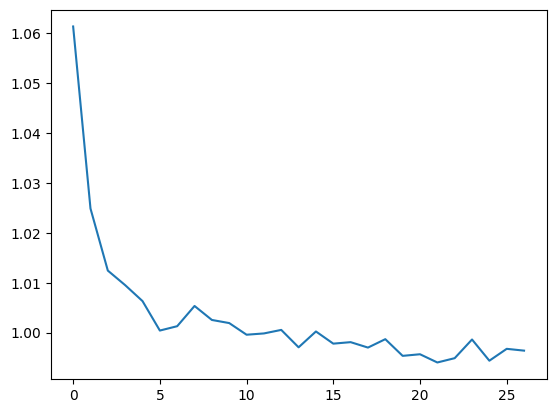

In [29]:
import matplotlib.pyplot as plt
plt.plot([np.mean(x) for x in train_loss])

In [40]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, [0, 1, 2, 3])
torch.cuda.empty_cache() if device == 'cuda' else None

In [41]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 62.72%


<Axes: >

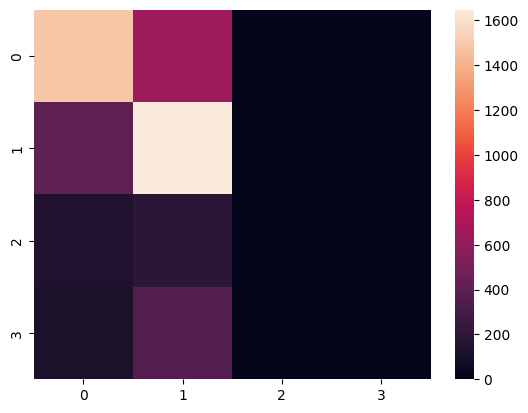

In [42]:
from seaborn import heatmap
heatmap(test_data[0])

In [33]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
            }, r'C:\Users\user\Desktop\dz\nlp\lab6\models\rubert-custom.model')